In [101]:
import numpy as np
import h5py
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import os

import sklearn.preprocessing as prep
import tensorflow as tf

from LstmVAE import LSTM_Var_Autoencoder
from LstmVAE import preprocess

name = '/home/mabbasloo/Documents/carData4/data/lbo/'
name1 = '/home/mabbasloo/Desktop/Variational-Lstm-Autoencoder/data/'

In [102]:
filename = '/home/mabbasloo/Desktop/Variational-Lstm-Autoencoder/list'

with open(filename) as f:
    data = f.readlines() 
data = [x.strip() for x in data]   
data = sorted(data, key=lambda x:x[0:4])
print (len(data), np.int(len(data)/60))
for i in range(60):
    print (data[i])
#print (data[len(data)-1])
#for i in range(len(data)):
#    print (data[i])

12300 205
f001_S2000001_1.mat
f001_S2000001_2.mat
f001_S2000001_3.mat
f001_S2000001_4.mat
f001_S2000001_5.mat
f001_S2000001_6.mat
f001_S2000001_7.mat
f001_S2000001_8.mat
f001_S2000001_9.mat
f001_S2000001_10.mat
f001_S2000001_11.mat
f001_S2000001_12.mat
f001_S2000001_13.mat
f001_S2000001_14.mat
f001_S2000001_15.mat
f001_S2000001_16.mat
f001_S2000001_17.mat
f001_S2000001_18.mat
f001_S2000001_19.mat
f001_S2000001_20.mat
f001_S2000001_21.mat
f001_S2000001_22.mat
f001_S2000001_23.mat
f001_S2000001_24.mat
f001_S2000001_25.mat
f001_S2000001_26.mat
f001_S2000001_27.mat
f001_S2000001_28.mat
f001_S2000001_29.mat
f001_S2000001_30.mat
f001_S2000001_31.mat
f001_S2000001_32.mat
f001_S2000001_33.mat
f001_S2000001_34.mat
f001_S2000001_35.mat
f001_S2000001_36.mat
f001_S2000001_37.mat
f001_S2000001_38.mat
f001_S2000001_39.mat
f001_S2000001_40.mat
f001_S2000001_41.mat
f001_S2000001_42.mat
f001_S2000001_43.mat
f001_S2000001_44.mat
f001_S2000001_45.mat
f001_S2000001_46.mat
f001_S2000001_47.mat
f001_S200000

In [103]:
DATA = []
d = 10
#hm = 20*60
hm = len(data)
dim = 1714
db = h5py.File(name + data[0], 'r')
ds = db['Phi']
ds = np.asarray(ds).astype(np.float32).T
ds = ds[:, 0:d]
ds[np.isnan(ds)] = 0.0
ds[np.isinf(ds)] = 0.0
for i in range(hm):
    #db = h5py.File(name + data[i], 'r')
    #ds = db['Phi']
    #ds = np.asarray(ds).astype(np.float32).T
    #ds = ds[:, 500-d:]
    #print (ds.shape)
    db1 = h5py.File(name1 + data[i], 'r')
    ds1 = db1['shape_xyz']
    ds1 = np.asarray(ds1).astype(np.float32)
    ds1[np.isnan(ds1)] = 0.0
    ds1[np.isinf(ds1)] = 0.0
    ds1[0] = ds1[0]/np.linalg.norm(ds1[0])
    ds1[1] = ds1[1]/np.linalg.norm(ds1[1])
    ds1[2] = ds1[2]/np.linalg.norm(ds1[2])    
    if ds1.shape[1] == dim: # f256_S2000001_6.mat has different dimension so f256_S2000001* are removed.
        DATA.append(np.dot(ds1, ds))
    else:
        print (data[i])     
print (len(DATA), DATA[0].shape)

dim = np.int(len(data)/60)

def standard_scale(X_train):
    for i in range(len(X_train)):
        X_train[i] = X_train[i]/np.linalg.norm(X_train[i], 'fro')
    return X_train

DATA = standard_scale(DATA)

12300 (3, 10)


Text(0.5, 0, 'z')

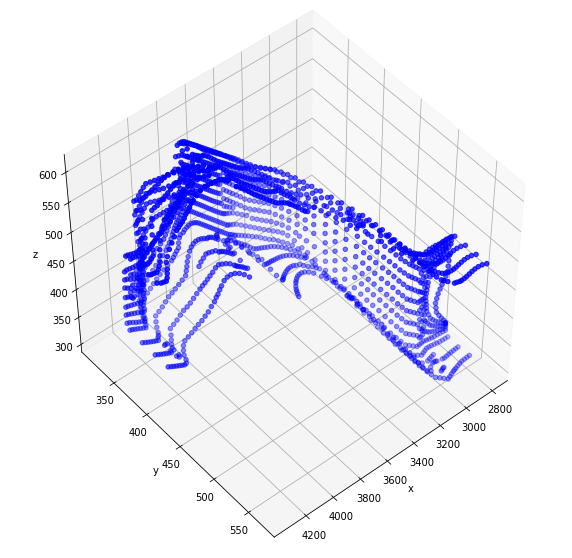

In [104]:
db1 = h5py.File(name1 + data[0], 'r')
ds1 = db1['shape_xyz']
ds1 = np.asarray(ds1).astype(np.float32)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ds1[0], ds1[1], ds1[2], c='b', marker='o')
ax.view_init(50, 50)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

(3, 1714)


Text(0.5, 0, 'z')

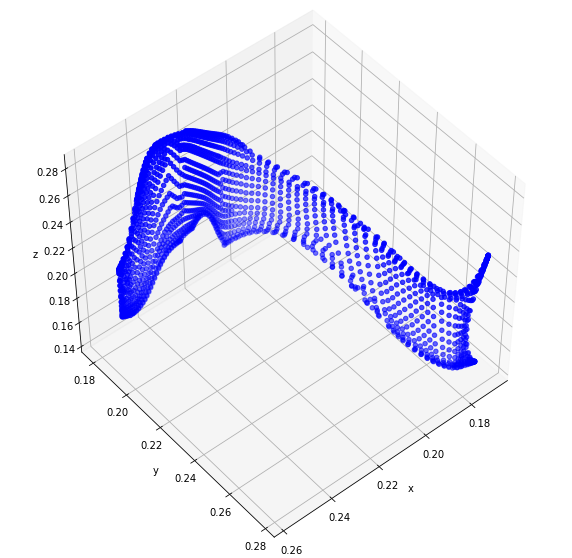

In [105]:
xyz = np.dot(DATA[0], np.linalg.pinv(ds))
print (xyz.shape)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xyz[0], xyz[1], xyz[2], c='b', marker='o')
ax.view_init(50, 50)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

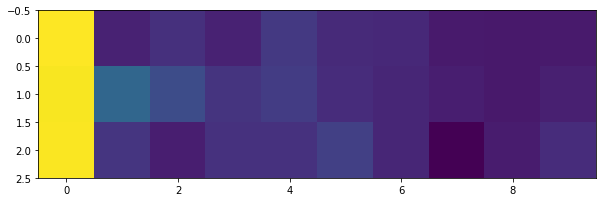

In [115]:
plt.figure(figsize=(10, 10)); 
plt.imshow(DATA[0])

In [116]:
dim2 = 100
vae = LSTM_Var_Autoencoder(intermediate_dim = 10, z_dim = 3, n_dim=d, stateful = False) #default stateful = False

vae.fit(DATA[0:dim2*60], learning_rate=0.001, batch_size = 10, num_epochs = 100, opt = tf.train.AdamOptimizer, REG_LAMBDA = 0.01, grad_clip_norm=10, optimizer_params=None, verbose = True)



Training...


Epoch   1    Loss 0.01026
Epoch   11   Loss 0.00002
Epoch   21   Loss 0.00002
Epoch   31   Loss 0.00002
Epoch   41   Loss 0.00002
Epoch   51   Loss 0.00002
Epoch   61   Loss 0.00002
Epoch   71   Loss 0.00002
Epoch   81   Loss 0.00002
Epoch   91   Loss 0.00002


Training time 10.67 minutes


In [117]:
x_reconstructed, recons_error = vae.reconstruct(DATA[dim2*60:], get_error = True) #returns squared error

x_reduced = vae.reduce(DATA) #latent space representation

Text(0.5, 0, 'latent 3')

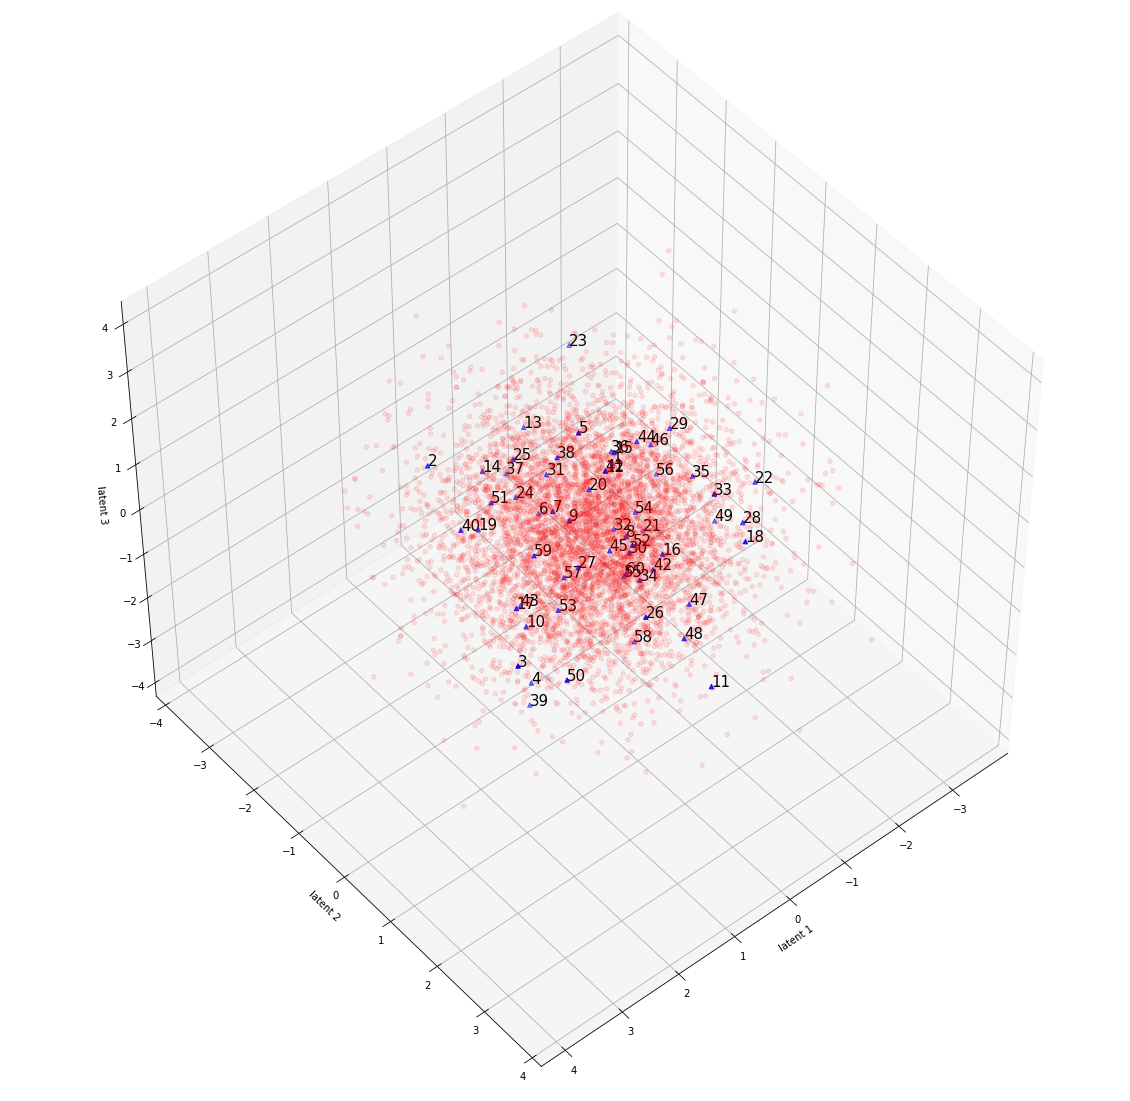

In [118]:
fig = plt.figure(figsize=(20, 20))
c = ['r', 'b']
m = ['o', '^']
label = []
for i in range(1, 60+1):
    label.append(np.str(i))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_reduced[0:dim2*60, 0], x_reduced[0:dim2*60, 1], x_reduced[0:dim2*60, 2], c=c[0], marker=m[0], alpha=0.1)
ax.scatter(x_reduced[dim2*60:(dim2+1)*60, 0], x_reduced[dim2*60:(dim2+1)*60, 1], x_reduced[dim2*60:(dim2+1)*60, 2], c=c[1], marker=m[1])
ii = 0
for i in range(dim2*60, (dim2+1)*60):
    ax.text(x_reduced[i, 0], x_reduced[i, 1], x_reduced[i, 2], label[ii], size=15, zorder=1, color='k') 
    ii += 1
ax.view_init(50, 50)
ax.set_xlabel('latent 1')
ax.set_ylabel('latent 2')
ax.set_zlabel('latent 3')

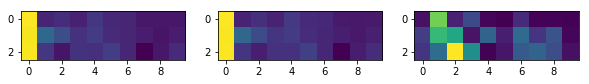

In [119]:
plt.figure(figsize=(10, 30)); 
plt.subplot(1,3,1); plt.imshow(x_reconstructed[0])
plt.subplot(1,3,2); plt.imshow(DATA[dim2*60])
plt.subplot(1,3,3); plt.imshow(np.abs(x_reconstructed[0] - DATA[dim2*60]))

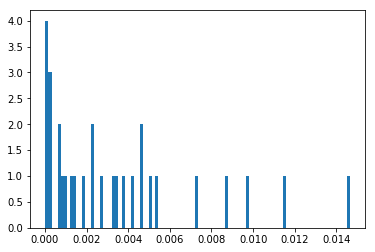

In [120]:
_,_,_ = plt.hist(np.abs(x_reconstructed[0] - DATA[dim2*60]).reshape((3*d)), bins=100)

(3, 1714)


Text(0.5, 0, 'z')

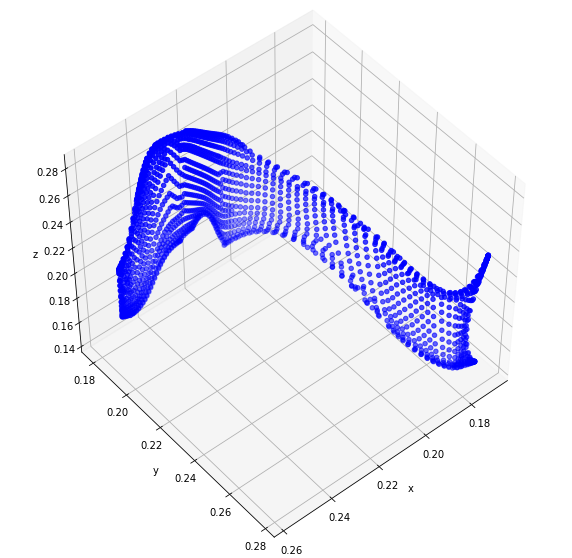

In [121]:
xyz = np.dot(DATA[dim2*60], np.linalg.pinv(ds))
print (xyz.shape)
fig = plt.figure(figsize=(10, 10))
c = ['b', 'r']
m = ['o', 'o']
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xyz[0], xyz[1], xyz[2], c=c[0], marker=m[0])
ax.view_init(50, 50)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

(3, 1714)


Text(0.5, 0, 'z')

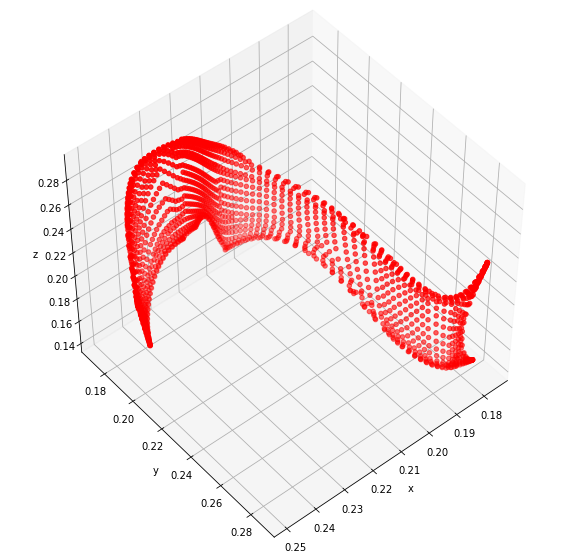

In [122]:
xyz_reconstructed = np.dot(x_reconstructed[0], np.linalg.pinv(ds))
print (xyz_reconstructed.shape)
fig = plt.figure(figsize=(10, 10))
c = ['b', 'r']
m = ['^', 'o']
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xyz_reconstructed[0], xyz_reconstructed[1], xyz_reconstructed[2], c=c[1], marker=m[1])
ax.view_init(50, 50)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

In [123]:
print (x_reduced.shape)
DATA2 = []
for i in range(dim):
    d = x_reduced[i*60:(i+1)*60].T
    #d[0] = d[0]/np.linalg.norm(d[0])
    #d[1] = d[1]/np.linalg.norm(d[1])
    #d[2] = d[2]/np.linalg.norm(d[2])

    DATA2.append(d)
print (len(DATA2), DATA2[0].shape)  
dd = 60
dim2 = 200

(12300, 3)
205 (3, 60)


In [124]:
vae2 = LSTM_Var_Autoencoder(intermediate_dim = 100, z_dim = 3, n_dim=dd, stateful = False) #default stateful = False

vae2.fit(DATA2[0:dim2], learning_rate=0.001, batch_size = 10, num_epochs = 200, opt = tf.train.AdamOptimizer, REG_LAMBDA = 0.01, grad_clip_norm=10, optimizer_params=None, verbose = True)



Training...


Epoch   1    Loss 1.14408
Epoch   11   Loss 0.99367
Epoch   21   Loss 1.00588
Epoch   31   Loss 0.99313
Epoch   41   Loss 0.99288
Epoch   51   Loss 0.99443
Epoch   61   Loss 0.99207
Epoch   71   Loss 0.99154
Epoch   81   Loss 0.99215
Epoch   91   Loss 0.99201
Epoch  101   Loss 0.99086
Epoch  111   Loss 0.99119
Epoch  121   Loss 0.99073
Epoch  131   Loss 0.99116
Epoch  141   Loss 0.99075
Epoch  151   Loss 0.99052
Epoch  161   Loss 0.99041
Epoch  171   Loss 0.99033
Epoch  181   Loss 0.99075
Epoch  191   Loss 0.99054


Training time 0.67 minutes


In [125]:
x_reconstructed2, recons_error2 = vae2.reconstruct(DATA2[dim2:], get_error = True) #returns squared error

x_reduced2 = vae2.reduce(DATA2) #latent space representation

Text(0.5, 0, 'latent 3')

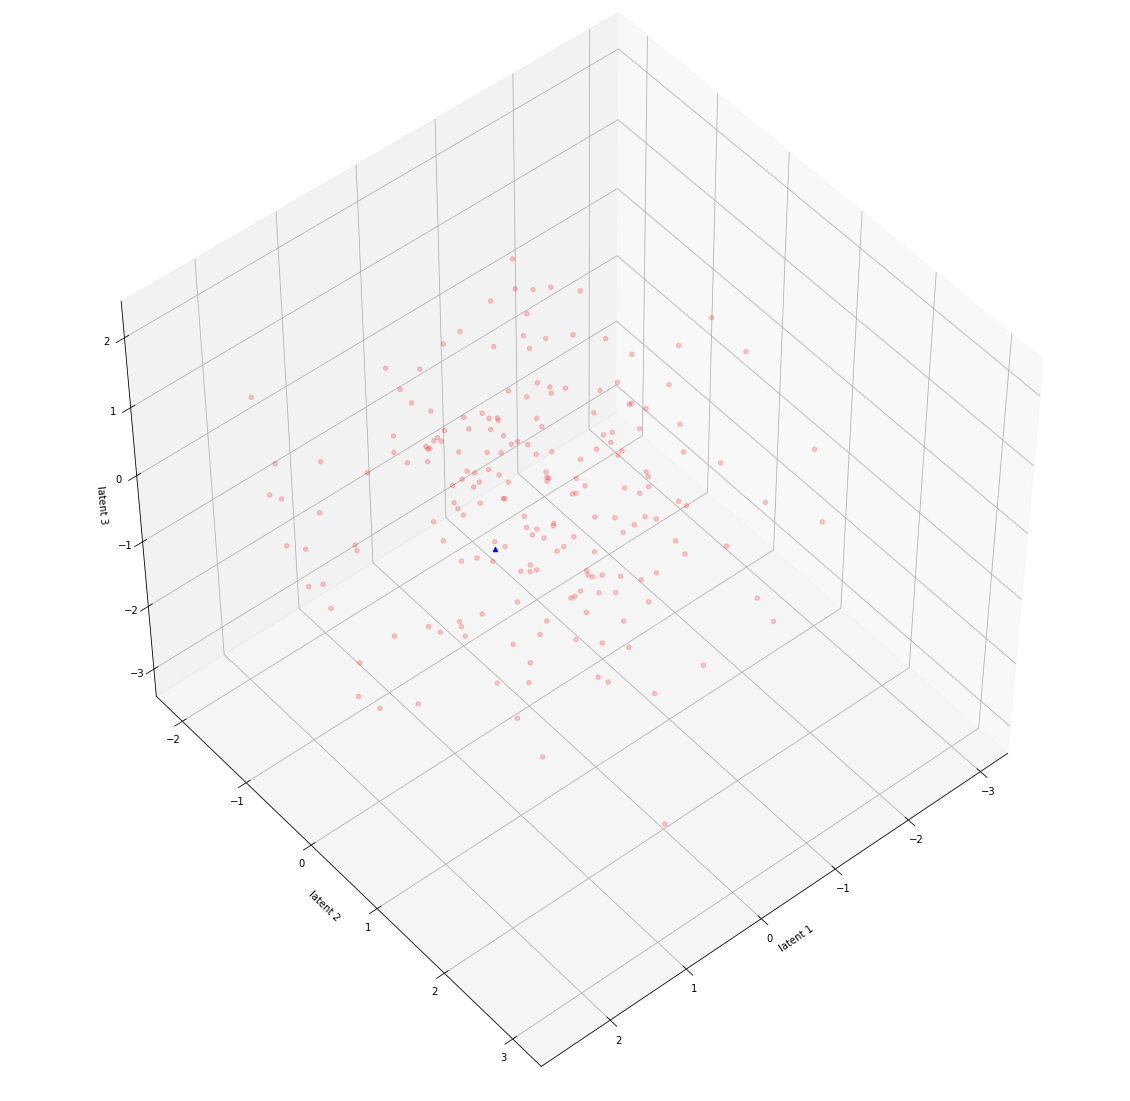

In [126]:
fig = plt.figure(figsize=(20, 20))
c = ['r', 'b']
m = ['o', '^']

ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_reduced2[0:dim2, 0], x_reduced2[0:dim2, 1], x_reduced2[0:dim2, 2], c=c[0], marker=m[0], alpha=0.2)
ax.scatter(x_reduced2[dim2:dim2+1, 0], x_reduced2[dim2:dim2+1, 1], x_reduced2[dim2:dim2+1, 2], c=c[1], marker=m[1])

ax.view_init(50, 50)
ax.set_xlabel('latent 1')
ax.set_ylabel('latent 2')
ax.set_zlabel('latent 3')

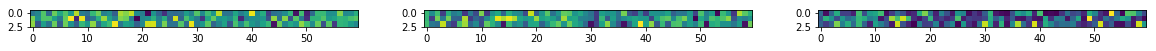

In [127]:
plt.figure(figsize=(20, 60)); 
plt.subplot(1,3,1); plt.imshow(x_reconstructed2[0])
plt.subplot(1,3,2); plt.imshow(DATA2[dim2])
plt.subplot(1,3,3); plt.imshow(np.abs(x_reconstructed2[0] - DATA2[dim2]))

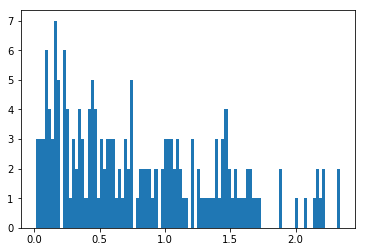

In [128]:
_,_,_ = plt.hist(np.abs(x_reconstructed2[0] - DATA2[dim2]).reshape((3*dd)), bins=100)